In [14]:
import pandas as pd
import numpy as np 
import re 



import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA



%load_ext autoreload
%autoreload 2
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# 1. Prepare Data

## 1.1 Import

In [20]:
df=pd.read_csv(r"E:\Mohamed\new_projects\data\SHIBUSDT_d_2021_5_1682698627.csv", index_col="timestamp", parse_dates=True)
df.index.freq='d'

In [21]:
df.head()
y=df.squeeze()
y.head()
returns=y.pct_change().dropna()
returns

timestamp
2021-05-11   -0.122331
2021-05-12   -0.401381
2021-05-13    0.154311
2021-05-14   -0.124643
2021-05-15   -0.155978
                ...   
2023-04-23   -0.013384
2023-04-24   -0.004845
2023-04-25    0.008763
2023-04-26   -0.018340
2023-04-27    0.009833
Freq: D, Name: close, Length: 717, dtype: float64

## 1.2 Explore

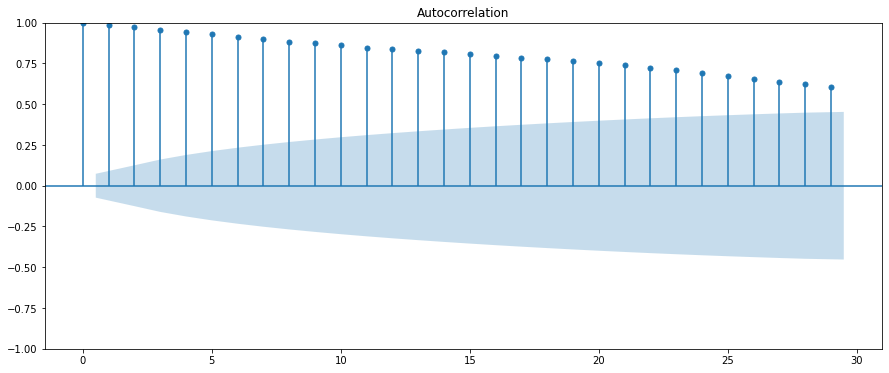

In [23]:
fi,ax=plt.subplots(figsize=(15,6))
plot_acf(y,ax=ax);

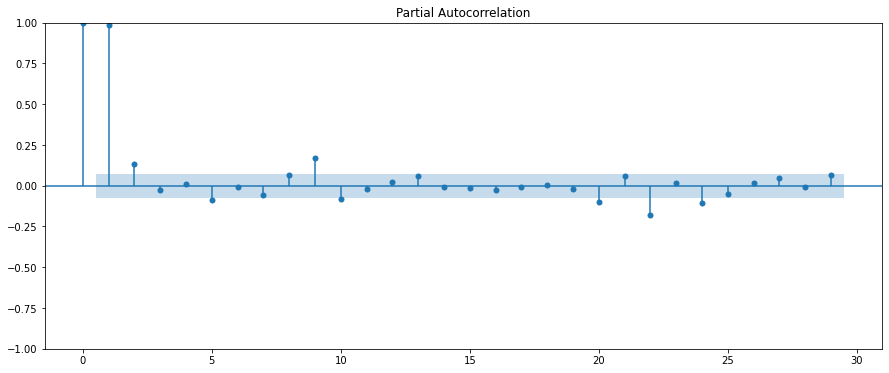

In [24]:
fi,ax=plt.subplots(figsize=(15,6))
plot_pacf(y,ax=ax);

## 1.3 Split

In [25]:
cut=int(len(df)*0.8)
y_train=df.iloc[:cut]
y_test=df.iloc[cut:]

# 2. Model

## 2.1 BaseLine

In [26]:
#calculate mean baseline
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean Close price:", round(y_train_mean[0],6))
print("Baseline MAE:", round(mae_baseline,6))

Mean Close price: 1.8e-05
Baseline MAE: 1e-05


## 2.2 Iterate


#  ** Grid Search **


In [29]:
p_params=range(0,25,8)
q_params=range(0,3,1)
#this dict for mae
grid_dict={}
history=y_train.copy().squeeze()
from tqdm import tqdm
for p in tqdm(p_params,colour='green'):
    grid_dict[p]=[]
    for q in tqdm(q_params,colour='yellow'):
        order = (p,0,q)
        #train the model
        model = ARIMA(history,order=order).fit()
        y_pred = model.predict()
        mae=mean_absolute_error(y_train,y_pred)
        #add mae to dict
        grid_dict[p].append(mae)
        
        

  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\Desco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Desco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Desco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 25%|██▌       | 1/4 [00:01<00:04,  1.56s/it]c:\Users\Desco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimizati

In [76]:
#get the min value from the dict
import seaborn as sns
meandf=pd.DataFrame(grid_dict)
#min in the dict
fig=px.bar(meandf,orientation="v")
fig.show()


In [77]:
grid_dict

{0: [9.28269799903329e-06, 5.098882267293575e-06, 6.214367379661814e-06],
 8: [1.066573467656152e-06, 1.0779423846089488e-06, 1.0676483833550963e-06],
 16: [1.0836549363210487e-06, 1.0948492924303088e-06, 1.101654474988986e-06],
 24: [1.1117008725054492e-06, 1.1372564070476836e-06, 1.1333054035828275e-06]}

## Best Model { 8 , 0 , 0 }

In [79]:
#lags should be a param as same as cutoff i think
# walk forward validation
from tqdm import tqdm

y_test=y_test.squeeze()
y_pred_wfv=pd.Series()
history=y_train.copy().squeeze()
for i in tqdm(range(len(y_test)),colour='green'):
    model = ARIMA(history,order=(8,0,0)).fit()
    next_pred=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next_pred)
    history=history.append(y_test[next_pred.index])

  0%|          | 0/144 [00:00<?, ?it/s]c:\Users\Desco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  1%|          | 1/144 [00:01<04:19,  1.82s/it]c:\Users\Desco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  1%|▏         | 2/144 [00:03<03:53,  1.65s/it]c:\Users\Desco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  2%|▏         | 3/144 [00:04<03:42,  1.58s/it]c:\Users\Desco\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  3%|▎         | 4/144 [00:06<03:36,

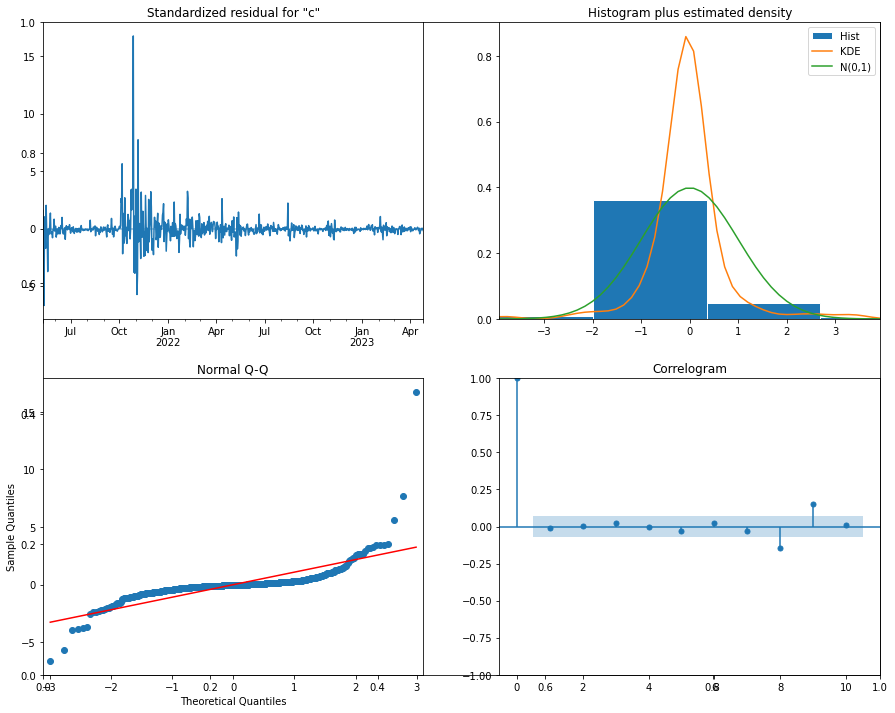

In [80]:
fig,ax=plt.subplots(figsize=(15,12))
model.plot_diagnostics(fig=fig);

## 3. Evaluate


In [81]:
test_mae=mean_absolute_error(y_test,y_pred_wfv)
print(f"Test MAE===>{test_mae} ")

Test MAE===>2.8513641094774927e-07 


In [82]:
df_pred=pd.DataFrame({"y_test":y_test,"y_pred":y_pred_wfv})
fig=px.line(df_pred)
fig.show()

In [4]:
model.resid.plt()

NameError: name 'model' is not defined